Loaded dataset with 21046 rows and 39 columns
Found 1 missing values in 'message' column. Replacing with empty string.
Training set: 16836 samples
Test set: 4210 samples
Features: 5000
Target categories: 37
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 128)               640128    
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 37)                2405      
                                             

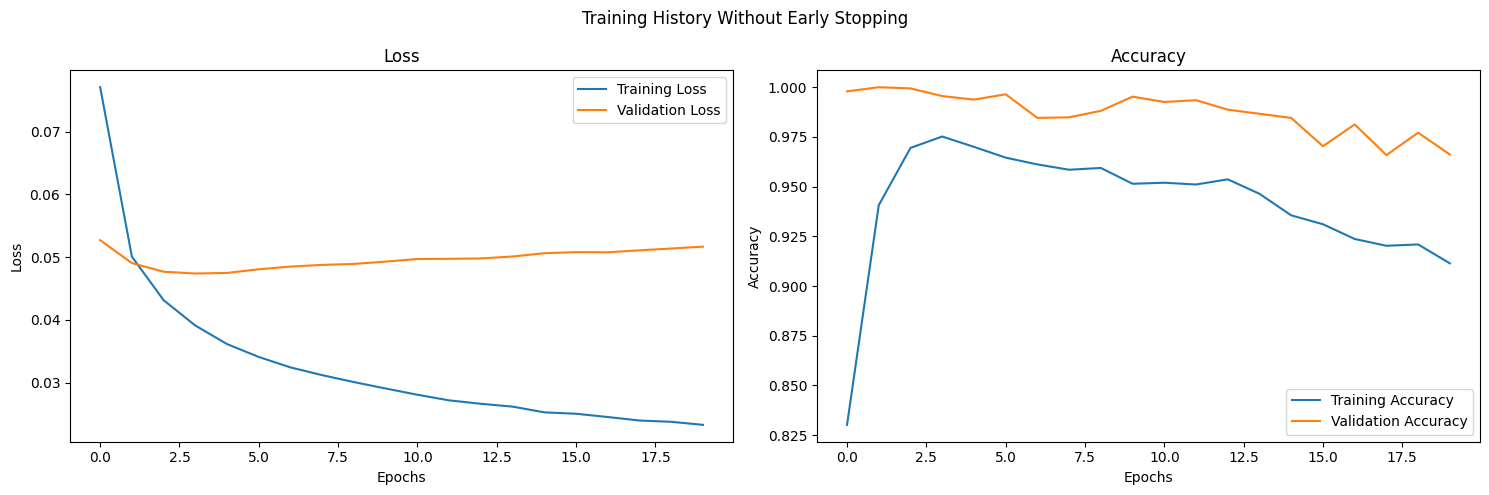

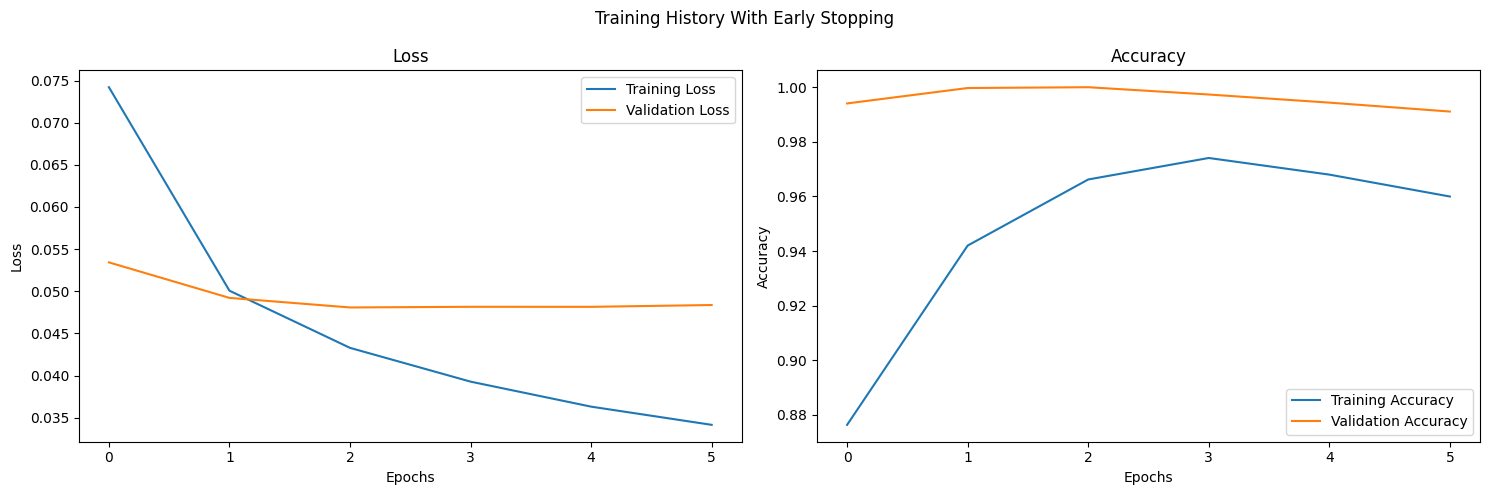

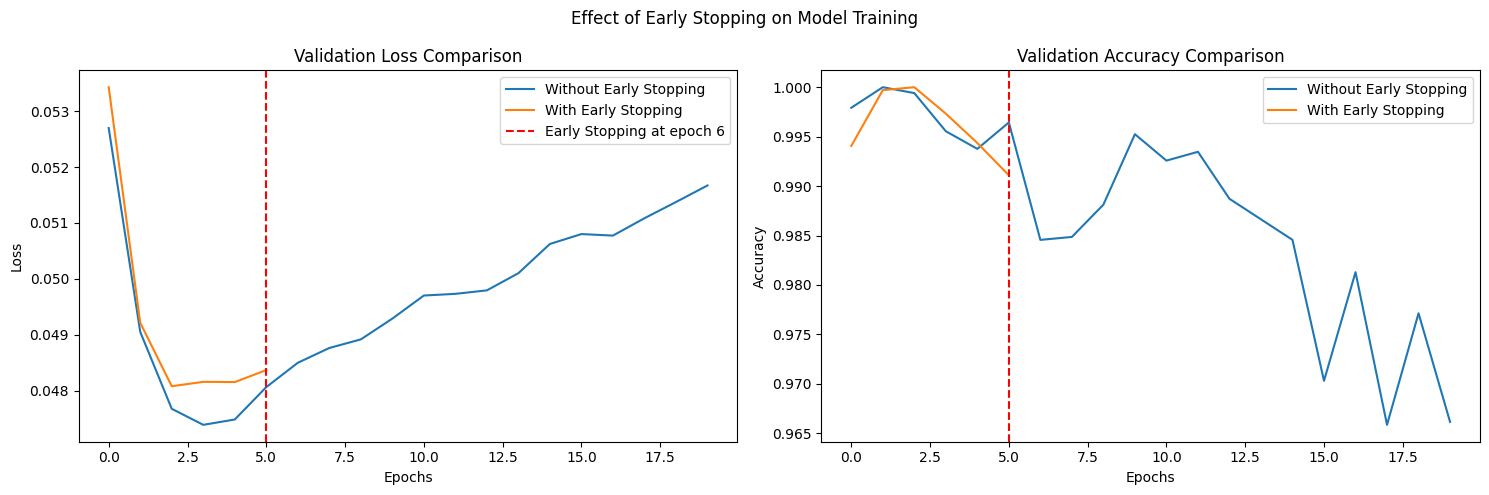

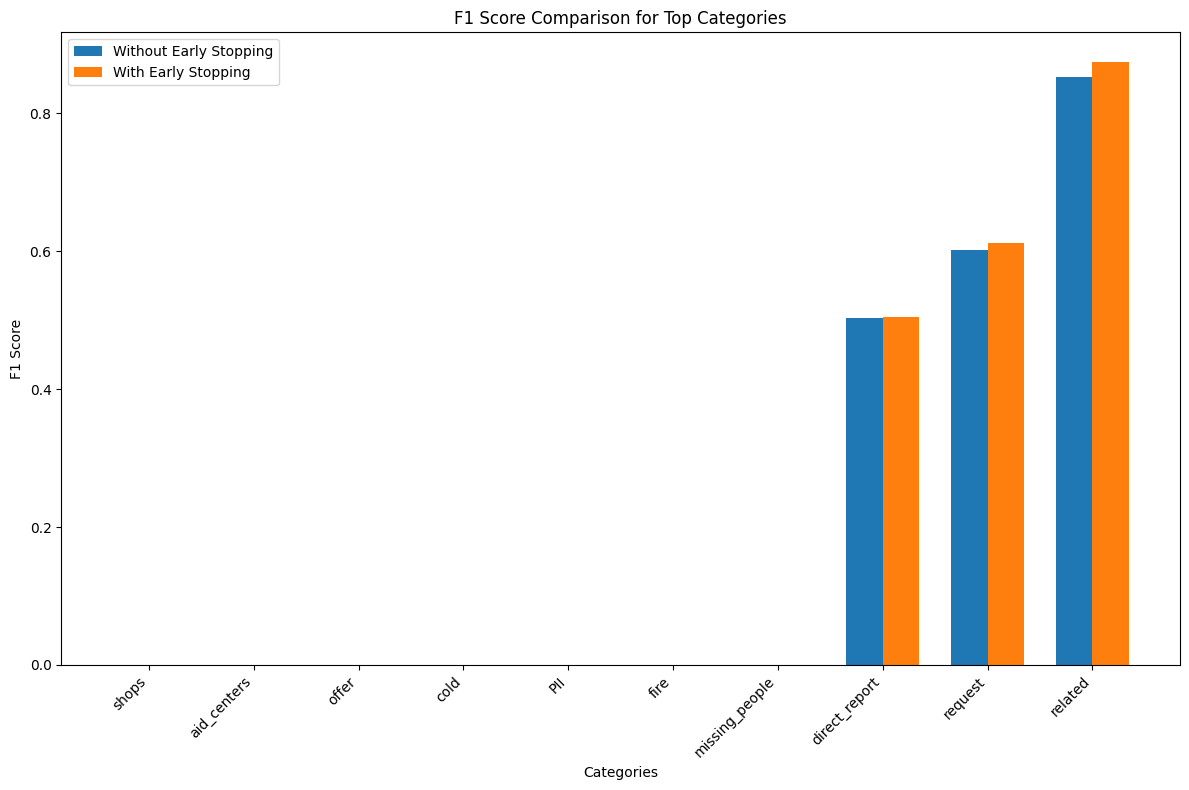


--- Performance Comparison ---
Model without early stopping - Epochs: 20, Accuracy: 0.9414, F1: 0.2504
Model with early stopping - Epochs: 6, Accuracy: 0.9440, F1: 0.1686

Early stopping reduced training epochs by 70.0%
Accuracy improved by 0.3%
F1 score decreased by 32.7%

Models saved successfully!


c:\Users\edwar\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [7]:
# disaster_response_classification.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

# Module 1: Data Loading and Preprocessing
class DataProcessor:
    def __init__(self, file_path):
        self.file_path = file_path
        self.data = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.feature_names = None
        self.target_names = None
        self.vectorizer = None
        self.scaler = None
        
    def load_data(self):
        """Load the disaster response dataset"""
        self.data = pd.read_csv(self.file_path)
        print(f"Loaded dataset with {self.data.shape[0]} rows and {self.data.shape[1]} columns")
        return self.data
    
    def preprocess_data(self, test_size=0.2, random_state=42):
        """Preprocess data and split into train/test sets"""
        # Separate features and targets
        X = self.data['message']
        
        # Check for and handle missing values in messages
        missing_mask = X.isna()
        if missing_mask.any():
            print(f"Found {missing_mask.sum()} missing values in 'message' column. Replacing with empty string.")
            X = X.fillna('')  # Replace NaN with empty string
        
        # Get all target columns (excluding message and genre columns)
        self.target_names = self.data.columns[2:]
        y = self.data[self.target_names].values  # Convert to numpy array
        
        # Make sure target values are numeric (convert any non-numeric to 0)
        y = y.astype(float)
        
        # Text preprocessing (converting text to numerical features using TF-IDF)
        from sklearn.feature_extraction.text import TfidfVectorizer
        self.vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
        X = self.vectorizer.fit_transform(X).toarray()
        self.feature_names = self.vectorizer.get_feature_names_out()
        
        # Split data
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state
        )
        
        # Scale features
        self.scaler = StandardScaler()
        self.X_train = self.scaler.fit_transform(self.X_train)
        self.X_test = self.scaler.transform(self.X_test)
        
        print(f"Training set: {self.X_train.shape[0]} samples")
        print(f"Test set: {self.X_test.shape[0]} samples")
        print(f"Features: {self.X_train.shape[1]}")
        print(f"Target categories: {len(self.target_names)}")
        
        return self.X_train, self.X_test, self.y_train, self.y_test

# Module 2: Model Architecture
class ModelBuilder:
    def __init__(self, input_dim, output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.model = None
        
    def build_model(self, hidden_layers=[128, 64], dropout_rate=0.3):
        """Build a multi-label classification model"""
        model = Sequential()
        
        # Input layer
        model.add(Dense(hidden_layers[0], input_dim=self.input_dim, activation='relu'))
        model.add(Dropout(dropout_rate))
        
        # Hidden layers
        for units in hidden_layers[1:]:
            model.add(Dense(units, activation='relu'))
            model.add(Dropout(dropout_rate))
        
        # Output layer (multi-label classification with sigmoid activation)
        model.add(Dense(self.output_dim, activation='sigmoid'))
        
        # Compile model
        model.compile(
            loss='mse',
            optimizer='adam',
            metrics=['accuracy']
        )
        
        self.model = model
        print(model.summary())
        return model

# Module 3: Training and Evaluation
class ModelTrainer:
    def __init__(self, model, X_train, y_train, X_test, y_test, target_names=None):
        self.model = model
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.history = None
        self.target_names = target_names
        
    def train_without_early_stopping(self, epochs=50, batch_size=32, validation_split=0.2):
        """Train the model without early stopping"""
        print("\nTraining model WITHOUT early stopping...")
        history = self.model.fit(
            self.X_train, self.y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=validation_split,
            verbose=1
        )
        self.history = history
        return history
    
    def train_with_early_stopping(self, epochs=50, batch_size=32, validation_split=0.2, patience=5):
        """Train the model with early stopping"""
        print("\nTraining model WITH early stopping...")
        # Define early stopping callback
        early_stopping = EarlyStopping(
            monitor='val_loss',  # Monitor validation loss
            patience=patience,   # Number of epochs with no improvement after which training will stop
            restore_best_weights=True,  # Restore model weights from the epoch with the best value of the monitored quantity
            verbose=1
        )
        
        history = self.model.fit(
            self.X_train, self.y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=validation_split,
            callbacks=[early_stopping],
            verbose=1
        )
        self.history = history
        return history
    
    def evaluate(self, threshold=0.5):
        """Evaluate the model on test data"""
        # Predict probabilities
        y_pred_proba = self.model.predict(self.X_test)
        
        # Convert probabilities to binary predictions using threshold
        y_pred = (y_pred_proba >= threshold).astype(int)
        
        # Manual calculation of accuracy and F1 score to avoid format issues
        accuracy = np.mean(np.equal(self.y_test, y_pred).all(axis=1))
        print(f"\nOverall Accuracy (exact matches): {accuracy:.4f}")
        
        # Calculate per-category metrics
        n_samples, n_labels = self.y_test.shape
        f1_scores = []
        accuracies = []
        precisions = []
        recalls = []
        
        print("\nPer-category metrics:")
        print(f"{'Category':<20} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1 Score':<10}")
        print("-" * 65)
        
        for i in range(n_labels):
            # True positives, false positives, etc.
            tp = np.sum((self.y_test[:, i] == 1) & (y_pred[:, i] == 1))
            fp = np.sum((self.y_test[:, i] == 0) & (y_pred[:, i] == 1))
            fn = np.sum((self.y_test[:, i] == 1) & (y_pred[:, i] == 0))
            tn = np.sum((self.y_test[:, i] == 0) & (y_pred[:, i] == 0))
            
            # Calculate metrics
            accuracy_i = (tp + tn) / (tp + fp + fn + tn) if (tp + fp + fn + tn) > 0 else 0
            precision_i = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall_i = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1_i = 2 * precision_i * recall_i / (precision_i + recall_i) if (precision_i + recall_i) > 0 else 0
            
            # Store metrics
            accuracies.append(accuracy_i)
            precisions.append(precision_i)
            recalls.append(recall_i)
            f1_scores.append(f1_i)
            
            # Print metrics for each category
            category_name = self.target_names[i] if self.target_names is not None else f"Category {i}"
            print(f"{category_name:<20} {accuracy_i:.4f}     {precision_i:.4f}     {recall_i:.4f}     {f1_i:.4f}")
        
        # Calculate overall metrics (macro averages)
        macro_accuracy = np.mean(accuracies)
        macro_precision = np.mean(precisions)
        macro_recall = np.mean(recalls)
        macro_f1 = np.mean(f1_scores)
        
        print("\nOverall metrics (macro average):")
        print(f"Accuracy: {macro_accuracy:.4f}")
        print(f"Precision: {macro_precision:.4f}")
        print(f"Recall: {macro_recall:.4f}")
        print(f"F1 Score: {macro_f1:.4f}")
        
        return macro_accuracy, macro_f1, {'precisions': precisions, 'recalls': recalls, 'f1_scores': f1_scores}

# Module 4: Visualization
class Visualizer:
    def __init__(self):
        pass
    
    def plot_training_history(self, history, title="Training History"):
        """Plot training and validation loss and accuracy"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot loss
        ax1.plot(history.history['loss'], label='Training Loss')
        ax1.plot(history.history['val_loss'], label='Validation Loss')
        ax1.set_title('Loss')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.legend()
        
        # Plot accuracy
        ax2.plot(history.history['accuracy'], label='Training Accuracy')
        ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
        ax2.set_title('Accuracy')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        
        plt.suptitle(title)
        plt.tight_layout()
        plt.show()
    
    def compare_training_histories(self, history_no_es, history_with_es):
        """Compare training histories of models with and without early stopping"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot validation loss
        ax1.plot(history_no_es.history['val_loss'], label='Without Early Stopping')
        ax1.plot(history_with_es.history['val_loss'], label='With Early Stopping')
        ax1.axvline(x=len(history_with_es.history['val_loss'])-1, color='r', linestyle='--', 
                   label=f'Early Stopping at epoch {len(history_with_es.history["val_loss"])}')
        ax1.set_title('Validation Loss Comparison')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.legend()
        
        # Plot validation accuracy
        ax2.plot(history_no_es.history['val_accuracy'], label='Without Early Stopping')
        ax2.plot(history_with_es.history['val_accuracy'], label='With Early Stopping')
        ax2.axvline(x=len(history_with_es.history['val_accuracy'])-1, color='r', linestyle='--')
        ax2.set_title('Validation Accuracy Comparison')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        
        plt.suptitle('Effect of Early Stopping on Model Training')
        plt.tight_layout()
        plt.show()
    
    def plot_metric_comparison(self, metrics_no_es, metrics_with_es, target_names=None):
        """Plot comparison of F1 scores between models with and without early stopping"""
        f1_no_es = metrics_no_es[2]['f1_scores']
        f1_with_es = metrics_with_es[2]['f1_scores']
        
        # Get category names
        categories = target_names if target_names is not None else [f"Category {i}" for i in range(len(f1_no_es))]
        
        # Sort by F1 score difference
        f1_diff = [es - no_es for es, no_es in zip(f1_with_es, f1_no_es)]
        sorted_indices = np.argsort(f1_diff)
        
        # Get top 10 categories with largest differences
        top_indices = sorted_indices[-10:]
        top_categories = [categories[i] for i in top_indices]
        top_f1_no_es = [f1_no_es[i] for i in top_indices]
        top_f1_with_es = [f1_with_es[i] for i in top_indices]
        
        # Plot
        fig, ax = plt.subplots(figsize=(12, 8))
        x = np.arange(len(top_categories))
        width = 0.35
        
        rects1 = ax.bar(x - width/2, top_f1_no_es, width, label='Without Early Stopping')
        rects2 = ax.bar(x + width/2, top_f1_with_es, width, label='With Early Stopping')
        
        ax.set_xlabel('Categories')
        ax.set_ylabel('F1 Score')
        ax.set_title('F1 Score Comparison for Top Categories')
        ax.set_xticks(x)
        ax.set_xticklabels(top_categories, rotation=45, ha='right')
        ax.legend()
        
        plt.tight_layout()
        plt.show()

# Module 5: Main Application
def main():
    # Step 1: Load and preprocess data
    processor = DataProcessor('disaster_response.csv')
    processor.load_data()
    X_train, X_test, y_train, y_test = processor.preprocess_data()
    
    # ---------- Model Without Early Stopping ----------
    # Step 2: Build model
    model_builder = ModelBuilder(input_dim=X_train.shape[1], output_dim=y_train.shape[1])
    model_no_es = model_builder.build_model()
    
    # Step 3: Train model without early stopping
    trainer_no_es = ModelTrainer(model_no_es, X_train, y_train, X_test, y_test, processor.target_names)
    # Use fewer epochs for demonstration
    history_no_es = trainer_no_es.train_without_early_stopping(epochs=20)
    
    # Step 4: Evaluate model
    print("\nEvaluation of model WITHOUT early stopping:")
    metrics_no_es = trainer_no_es.evaluate()
    
    # ---------- Model With Early Stopping ----------
    # Step 2: Build model (with same architecture)
    model_builder = ModelBuilder(input_dim=X_train.shape[1], output_dim=y_train.shape[1])
    model_with_es = model_builder.build_model()
    
    # Step 3: Train model with early stopping
    trainer_with_es = ModelTrainer(model_with_es, X_train, y_train, X_test, y_test, processor.target_names)
    history_with_es = trainer_with_es.train_with_early_stopping(epochs=50, patience=3)
    
    # Step 4: Evaluate model
    print("\nEvaluation of model WITH early stopping:")
    metrics_with_es = trainer_with_es.evaluate()
    
    # Step 5: Visualize results
    visualizer = Visualizer()
    visualizer.plot_training_history(history_no_es, "Training History Without Early Stopping")
    visualizer.plot_training_history(history_with_es, "Training History With Early Stopping")
    visualizer.compare_training_histories(history_no_es, history_with_es)
    visualizer.plot_metric_comparison(metrics_no_es, metrics_with_es, processor.target_names)
    
    # Compare results
    print("\n--- Performance Comparison ---")
    print(f"Model without early stopping - Epochs: {len(history_no_es.history['loss'])}, Accuracy: {metrics_no_es[0]:.4f}, F1: {metrics_no_es[1]:.4f}")
    print(f"Model with early stopping - Epochs: {len(history_with_es.history['loss'])}, Accuracy: {metrics_with_es[0]:.4f}, F1: {metrics_with_es[1]:.4f}")
    
    # Calculate improvement
    acc_improvement = (metrics_with_es[0] - metrics_no_es[0]) / metrics_no_es[0] * 100
    f1_improvement = (metrics_with_es[1] - metrics_no_es[1]) / metrics_no_es[1] * 100
    epoch_reduction = (len(history_no_es.history['loss']) - len(history_with_es.history['loss'])) / len(history_no_es.history['loss']) * 100
    
    print(f"\nEarly stopping reduced training epochs by {epoch_reduction:.1f}%")
    print(f"Accuracy {'improved' if acc_improvement > 0 else 'decreased'} by {abs(acc_improvement):.1f}%")
    print(f"F1 score {'improved' if f1_improvement > 0 else 'decreased'} by {abs(f1_improvement):.1f}%")
    
    # Save models
    try:
        model_no_es.save("disaster_response_model_no_es.h5")
        model_with_es.save("disaster_response_model_with_es.h5")
        print("\nModels saved successfully!")
    except Exception as e:
        print(f"Error saving models: {e}")

# If this script is run directly, execute the main function
if __name__ == "__main__":
    try:
        main()
    except Exception as e:
        print(f"Error occurred: {e}")
        import traceback
        traceback.print_exc()